# Single element simulation

## Steps: 

1. Finding nominal stress-strain curves for material Flexible 80A
2. Load test data curves into abaqus to find constants for material models 
3. modify parameters in models to fit curves

## For comparison: 

- UT - test data from test UT_4 
- E-module and ny from litterature 
- Material data from datasheet Flexible 80A 



In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import trapezoid
from scipy.stats import linregress

In [53]:
# FUNCTIONS

def plot_2_arrays(xValues, yValues, xLabel, yLabel, title):
    plt.figure(figsize=(10,6))
    plt.plot(xValues, yValues)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.grid()
    plt.show()

#Nominell stress-strain
def nominalStressStrain(Force, Area, Length0, displacement):
    SigmaEng = Force/Area
    EpsEng = displacement/Length0
    return SigmaEng, EpsEng     

def DispAndTime_FromExcel_UC(fileName, sheetName, dt):
    pix_mm_ratio = 1771/10 
    # Importing data 
    data = pd.read_excel(fileName, sheetName)
    disp_pix = np.array(data['Location v [pix]'])
    # Converting displacement from pix to mm 
    disp = (disp_pix-disp_pix[0])/pix_mm_ratio
    total_time = dt*(len(disp)-1)
    time = np.linspace(0,total_time,len(disp))
    return disp, time
# Function that reads an exelfile and returns displacement and force

def ForceAndDisp_FromExcel(filename, sheetname):
    Data = pd.read_excel(filename, sheet_name=sheetname)
    disp = np.array(Data['Displacement (mm)'])
    force = np.array(Data['Force (kN)'])
    return force, disp

def locationDisplacement_FromExcel(filename, sheetname):
    Data = pd.read_excel(filename, sheet_name=sheetname)

    frameID = np.array(Data['Frame Id'])

    force = np.array(Data['Force (kN)'])

    s0 = np.array(Data['s0'])
    s1 = np.array(Data['s1'])
    s2 = np.array(Data['s2'])
    s3 = np.array(Data['s3'])
    s4 = np.array(Data['s4'])
    s5 = np.array(Data['s5'])

    return frameID, force, s0, s1, s2, s3, s4, s5

def stress_calc(force, diameter):
    area = np.pi * (diameter/2)**2
    stress = (force*10**3) / area
    return np.array(stress)

def strain_2_displ(s0, s1):
    length = s1-s0 
    l0 = length[0]
    strain = (length-l0)/l0
    return strain


# UC Test data - preliminary tests vegard

In [54]:
force_UC_1, disp_UC_1 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_1')
force_UC_2, disp_UC_2 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_2')
force_UC_3, disp_UC_3 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_3')
force_UC_4, disp_UC_4 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_4')
force_UC_5, disp_UC_5 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_5')
force_UC_6, disp_UC_6 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_6')
force_UC_7, disp_UC_7 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_7')
force_UC_8, disp_UC_8 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_8')
force_UC_9, disp_UC_9 = ForceAndDisp_FromExcel('Preliminary_tests_data.xlsx', 'UC_9')

In [55]:
#plot_2_arrays(-disp_UC_1[:500], -force_UC_1[:500], 'Displacement [mm]', 'Force [kN]', 'UC_1')
#plot_2_arrays(-disp_UC_2[:1300], -force_UC_2[:1300], 'Displacement [mm]', 'Force [kN]', 'UC_2')
#plot_2_arrays(-disp_UC_3[:1000], -force_UC_3[:1000], 'Displacement [mm]', 'Force [kN]', 'UC_3')
#plot_2_arrays(-disp_UC_4, -force_UC_4, 'Displacement [mm]', 'Force [kN]', 'UC_4')
#plot_2_arrays(-disp_UC_5, -force_UC_5, 'Displacement [mm]', 'Force [kN]', 'UC_5')
#plot_2_arrays(-disp_UC_6, -force_UC_6, 'Displacement [mm]', 'Force [kN]', 'UC_6')
#plot_2_arrays(-disp_UC_7, -force_UC_7, 'Displacement [mm]', 'Force [kN]', 'UC_7')   
#plot_2_arrays(-disp_UC_8, -force_UC_8, 'Displacement [mm]', 'Force [kN]', 'UC_8')   
#plot_2_arrays(-disp_UC_9, -force_UC_9, 'Displacement [mm]', 'Force [kN]', 'UC_9')

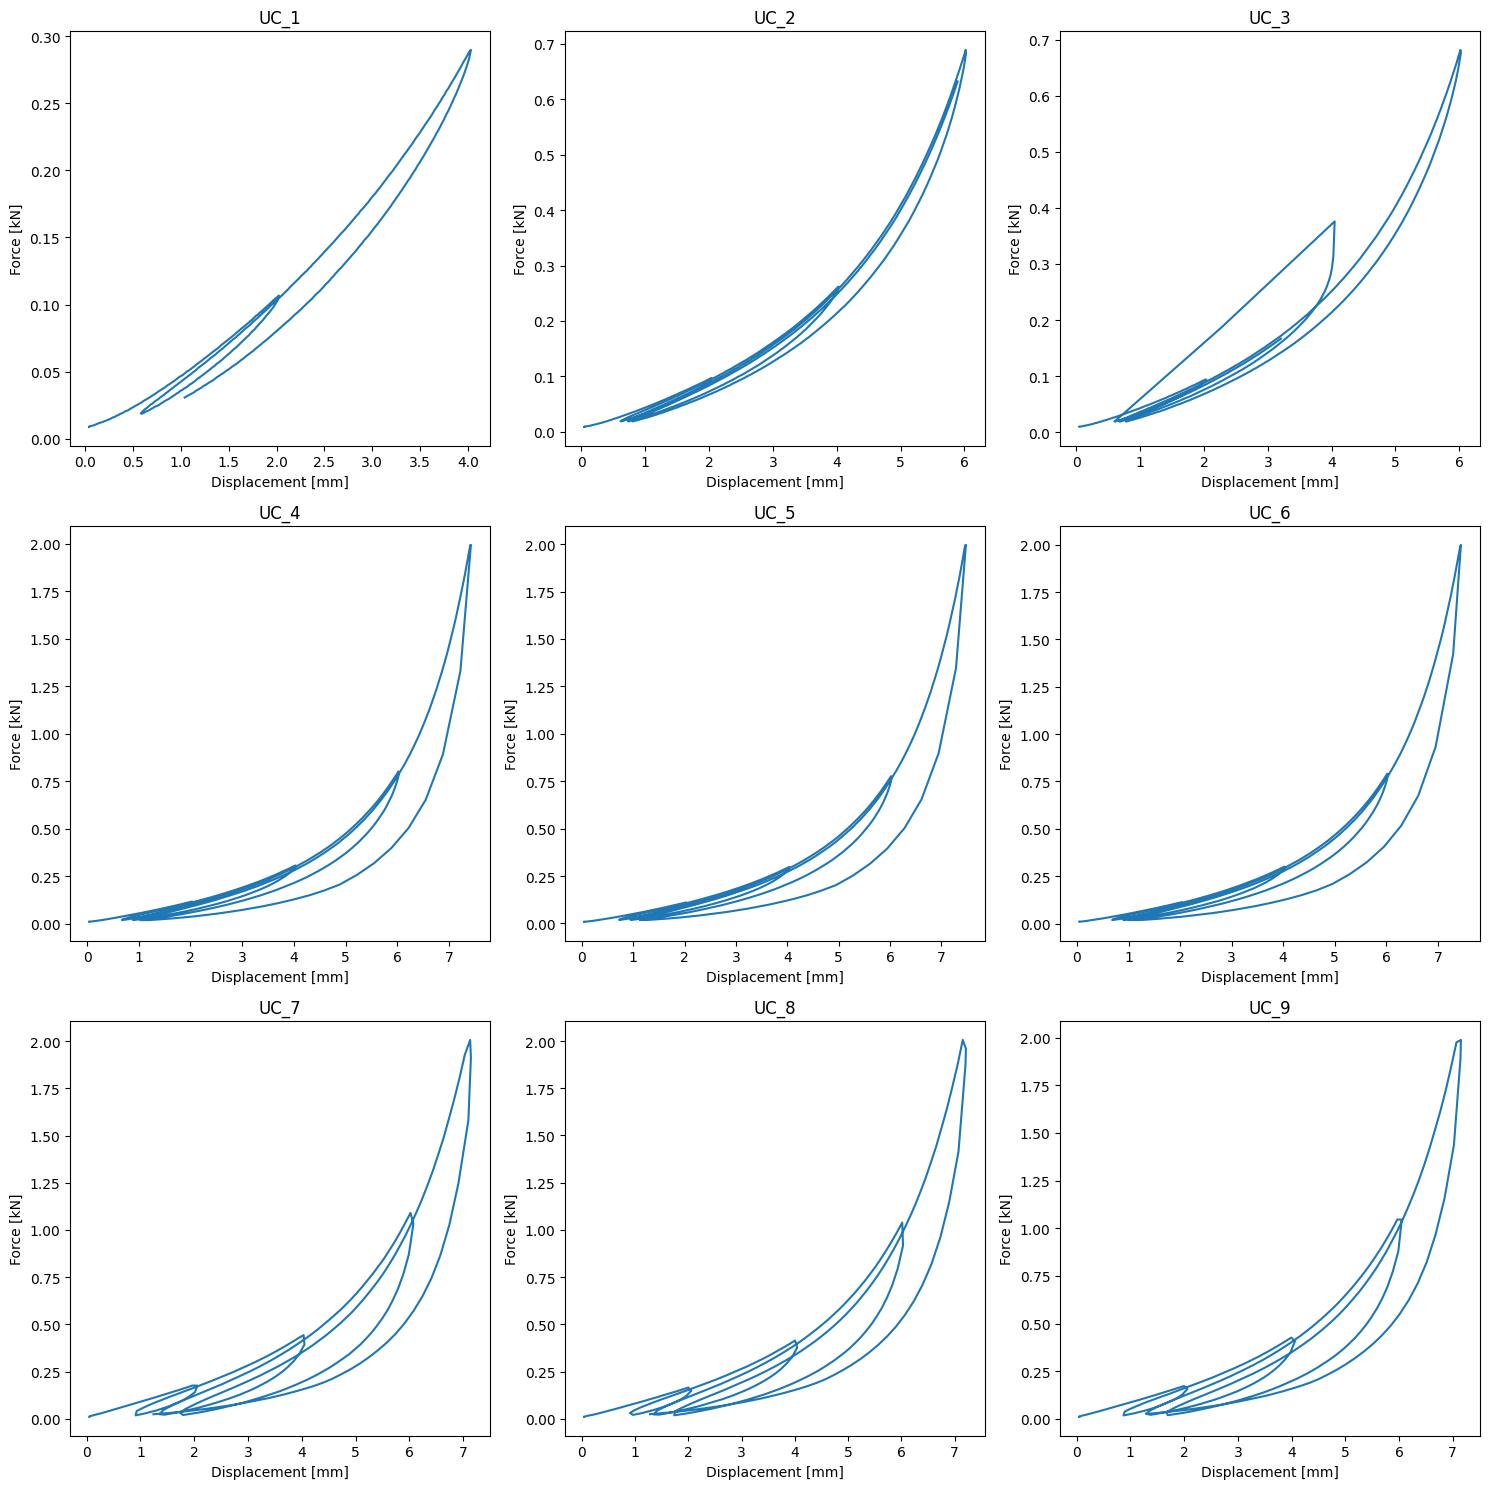

In [56]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows, 3 columns

# Plotting each subplot
axs[0, 0].plot(-disp_UC_1[:500], -force_UC_1[:500])
axs[0, 0].set_title('UC_1')
axs[0, 0].set_xlabel('Displacement [mm]')
axs[0, 0].set_ylabel('Force [kN]')

axs[0, 1].plot(-disp_UC_2[:1300], -force_UC_2[:1300])
axs[0, 1].set_title('UC_2')
axs[0, 1].set_xlabel('Displacement [mm]')
axs[0, 1].set_ylabel('Force [kN]')

axs[0, 2].plot(-disp_UC_3[:1000], -force_UC_3[:1000])
axs[0, 2].set_title('UC_3')
axs[0, 2].set_xlabel('Displacement [mm]')
axs[0, 2].set_ylabel('Force [kN]')

axs[1, 0].plot(-disp_UC_4, -force_UC_4)
axs[1, 0].set_title('UC_4')
axs[1, 0].set_xlabel('Displacement [mm]')
axs[1, 0].set_ylabel('Force [kN]')

axs[1, 1].plot(-disp_UC_5, -force_UC_5)
axs[1, 1].set_title('UC_5')
axs[1, 1].set_xlabel('Displacement [mm]')
axs[1, 1].set_ylabel('Force [kN]')

axs[1, 2].plot(-disp_UC_6, -force_UC_6)
axs[1, 2].set_title('UC_6')
axs[1, 2].set_xlabel('Displacement [mm]')
axs[1, 2].set_ylabel('Force [kN]')

axs[2, 0].plot(-disp_UC_7, -force_UC_7)
axs[2, 0].set_title('UC_7')
axs[2, 0].set_xlabel('Displacement [mm]')
axs[2, 0].set_ylabel('Force [kN]')

axs[2, 1].plot(-disp_UC_8, -force_UC_8)
axs[2, 1].set_title('UC_8')
axs[2, 1].set_xlabel('Displacement [mm]')
axs[2, 1].set_ylabel('Force [kN]')

axs[2, 2].plot(-disp_UC_9, -force_UC_9)
axs[2, 2].set_title('UC_9')
axs[2, 2].set_xlabel('Displacement [mm]')
axs[2, 2].set_ylabel('Force [kN]')

# Adjust layout
plt.tight_layout()
plt.show()

In [57]:
# Create a DataFrame from the arrays
df = pd.DataFrame({
    'Displacement [mm]': disp_UC_DIC_2,
    'Force [N]': -force_UC_2
})

# Write the DataFrame to a CSV file
df.to_csv('arrays_for_abaqus.csv', index=False)

NameError: name 'disp_UC_DIC_2' is not defined

# UT - preliminary tensile test (Vegard)

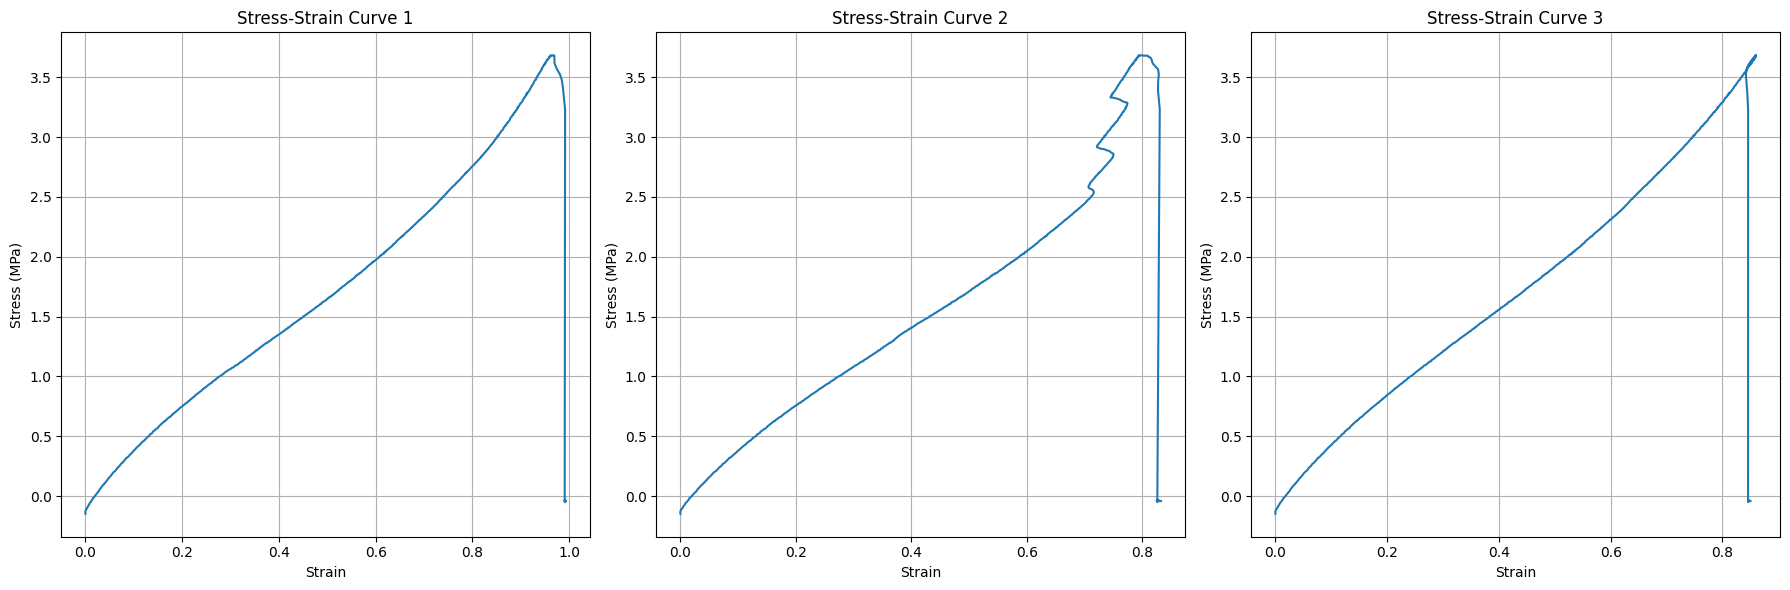

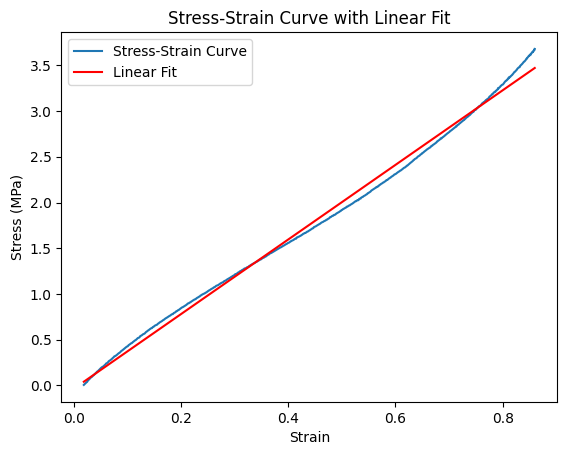

Slope (E-modulus): 4.08 MPa


In [58]:
#defining arrays
frameID, force, s0, s1, s2, s3, s4, s5 = locationDisplacement_FromExcel('UT_4_frame_displ.xlsx', 'UT_4')
#calculating strains
strain1, strain2, strain3 = strain_2_displ(s0, s1), strain_2_displ(s2, s3), strain_2_displ(s4, s5)
#calculating stresses
d=5 #mm
stress = stress_calc(force, d)

#plotting stress-strain curves
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plotting each subplot
axs[0].plot(strain1, stress)
axs[0].set_title('Stress-Strain Curve 1')
axs[0].set_xlabel('Strain')
axs[0].set_ylabel('Stress (MPa)')
axs[0].grid()

axs[1].plot(strain2, stress)
axs[1].set_title('Stress-Strain Curve 2')
axs[1].set_xlabel('Strain')
axs[1].set_ylabel('Stress (MPa)')
axs[1].grid()

axs[2].plot(strain3, stress)
axs[2].set_title('Stress-Strain Curve 3')
axs[2].set_xlabel('Strain')
axs[2].set_ylabel('Stress (MPa)')
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

def E_module(stress, strain):
    max_value = np.nanmax(stress)
    max_index = np.where(stress == max_value)[0][0]
    #print(f'max stress value: {max_value}')
    first_positive_index = np.argmax(stress > 0)

    stress = stress[first_positive_index:max_index]
    strain = strain[first_positive_index:max_index]

    slope, intercept, r_value, p_value, std_err = linregress(strain, stress)
    #plot_2_arrays(strain, stress, 'Strain', 'Stress (MPa)', 'Stress-Strain Curve sliced')
    
    # Plot the stress-strain curve and the linear fit
    plt.figure()
    plt.plot(strain, stress, label='Stress-Strain Curve')
    plt.plot(strain, intercept + slope * strain, 'r', label='Linear Fit')
    plt.xlabel('Strain')
    plt.ylabel('Stress (MPa)')
    plt.title('Stress-Strain Curve with Linear Fit')
    plt.legend()
    plt.show()
    print(f"Slope (E-modulus): {round(slope,3)} MPa")

#test
E_module(stress, strain3) 

exp_stress = stress
exp_strain = strain3    

# Neo Hook constants calculations

- From deshpande 23 for flexible 80A:     E-module = 8.925, ny = 0.48
- From vegards uniaxial test:   E-module = 4.08

In [59]:
# Neo Hook constants calculations
def neoHook_param(E, nu):
    mu0 = E/(2*(1+nu))
    C10 = mu0 / 2.0 
    K0 = E/(3*(1-2*nu)) #sjekk om det skal være 2 noe sted
    D1 = 2/K0
    print(F"For E-module: {E} and nu: {nu} Neo hook:  D1: {round(D1,3)}, C10: {round(C10,3)} ") 
    return D1, C10

D1_a, C1_a = neoHook_param(4.08, 0.48)
D1_b, C1_b = neoHook_param(8.925, 0.48)

For E-module: 4.08 and nu: 0.48 Neo hook:  D1: 0.059, C10: 0.689 
For E-module: 8.925 and nu: 0.48 Neo hook:  D1: 0.027, C10: 1.508 


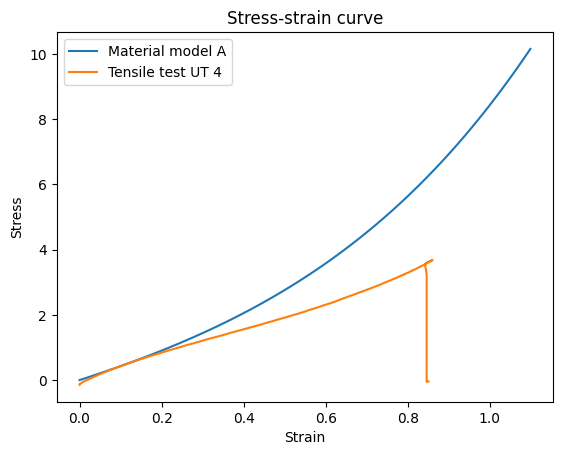

In [ ]:
NHdata_a = np.genfromtxt('EM_stress-strain_mat_a.rpt',delimiter='', skip_header=4)
strain_NH_a = NHdata_a[:,0]
stress_NH_a = NHdata_a[:,1]
# compairison material model A with tensile test: 

plt.plot(strain_NH_a, stress_NH_a, label='Material model A')
plt.plot(exp_strain, exp_stress, label='Tensile test UT 4')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress-strain curve')
plt.legend()
plt.show()
